# In this notebook a sensitivity analysis will be performed. The best Automatic Trader will be trained and tested many times, with the SPY symbol, to assess the sensitivity to changes in the random conditions of training.

In [1]:
# Basic imports
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import datetime as dt
import scipy.optimize as spo
import sys
from time import time
from sklearn.metrics import r2_score, median_absolute_error
from multiprocessing import Pool
import pickle

%matplotlib inline

%pylab inline
pylab.rcParams['figure.figsize'] = (20.0, 10.0)

%load_ext autoreload
%autoreload 2

sys.path.append('../../')

import recommender.simulator as sim
from utils.analysis import value_eval
from recommender.agent import Agent
from functools import partial

Populating the interactive namespace from numpy and matplotlib


In [2]:
def show_results(results_list, data_in_df, symbol, graph=False):
    for values in results_list:
        total_value = values.sum(axis=1)
        print('Sharpe ratio: {}\nCum. Ret.: {}\nAVG_DRET: {}\nSTD_DRET: {}\nFinal value: {}'.format(*value_eval(pd.DataFrame(total_value))))
        print('-'*100)
        initial_date = total_value.index[0]
        compare_results = data_in_df.loc[initial_date:, 'Close'].copy()
        compare_results.name = symbol
        compare_results_df = pd.DataFrame(compare_results)
        compare_results_df['portfolio'] = total_value
        std_comp_df = compare_results_df / compare_results_df.iloc[0]
        if graph:
            plt.figure()
            std_comp_df.plot()

## Let's test training with SPY n_train times

In [3]:
n_train = 20

STARTING_DAYS_AHEAD = 252
POSSIBLE_FRACTIONS = [0.0, 1.0]

# Get the global data
total_data_train_df = pd.read_pickle('../../data/data_train_val_df.pkl').stack(level='feature')
total_data_test_df = pd.read_pickle('../../data/data_test_df.pkl').stack(level='feature')

symbols = ['SPY'] * n_train
print('Testing with these symbols:\n{}'.format(symbols))

# Results holder
results_df = pd.DataFrame(columns=['sharpe', 
                                   'sharpe_bench', 
                                   'cum_ret', 
                                   'cum_ret_bench', 
                                   'sharpe_quotient', 
                                   'cum_ret_quotient',])

for symbol in symbols:
    # Set the environment
    data_train_df = total_data_train_df[symbol].unstack()
    data_test_df = total_data_test_df[symbol].unstack()
    data_in_df = data_train_df
    env, num_states, num_actions = sim.initialize_env(total_data_train_df, 
                                                  symbol, 
                                                  starting_days_ahead=STARTING_DAYS_AHEAD,
                                                  possible_fractions=POSSIBLE_FRACTIONS,
                                                  n_levels=10)
    # Create the Agent
    agent = Agent(num_states=num_states, 
                num_actions=num_actions, 
                random_actions_rate=0.98, 
                random_actions_decrease=0.9999,
                dyna_iterations=0,
                name='Agent_0')
    
    # Train
    print('Training: {}'.format(symbol))
    n_epochs = 7

    for i in range(n_epochs):
        tic = time()
        env.reset(STARTING_DAYS_AHEAD)
        results_list = sim.simulate_period(total_data_train_df, 
                                           symbol,
                                           agent,
                                           starting_days_ahead=STARTING_DAYS_AHEAD,
                                           possible_fractions=POSSIBLE_FRACTIONS,
                                           verbose=False,
                                           other_env=env)
        toc = time()
        print('Epoch: {}'.format(i))
        print('Elapsed time: {} seconds.'.format((toc-tic)))
        print('Random Actions Rate: {}'.format(agent.random_actions_rate))
        show_results([results_list], data_in_df, symbol)
    
    
    # Test
    print('-'*100)
    print('Testing: {}'.format(symbol))
    TEST_DAYS_AHEAD = 20
    env.set_test_data(total_data_test_df, TEST_DAYS_AHEAD)
    tic = time()
    results_list = sim.simulate_period(total_data_test_df, 
                                    symbol,
                                    agent,
                                    learn=False,
                                    starting_days_ahead=TEST_DAYS_AHEAD,
                                    possible_fractions=POSSIBLE_FRACTIONS,
                                    verbose=False,
                                    other_env=env)
    toc = time()
    
    # Show results
    print('Elapsed time: {} seconds.'.format((toc-tic)))
    print('Random Actions Rate: {}'.format(agent.random_actions_rate))
    show_results([results_list], data_test_df, symbol, graph=False)
    print('-'*100)
    
    # Save some results
    total_value = results_list.sum(axis=1)
    sharpe, cumret, _, _, _ = value_eval(pd.DataFrame(total_value))
    sharpe_bench, cumret_bench, _, _, _ = value_eval(pd.DataFrame(data_test_df['Close'].iloc[TEST_DAYS_AHEAD:]))
    sharpe_q = sharpe / sharpe_bench
    cumret_q = cumret / cumret_bench
    results_df = results_df.append(pd.DataFrame({symbol: {'sharpe': sharpe,
                                         'sharpe_bench': sharpe_bench,
                                         'cum_ret': cumret,
                                         'cum_ret_bench': cumret_bench,
                                         'sharpe_quotient': sharpe_q,
                                         'cum_ret_quotient': cumret_q}}).T)

Testing with these symbols:
['SPY', 'SPY', 'SPY', 'SPY', 'SPY', 'SPY', 'SPY', 'SPY', 'SPY', 'SPY', 'SPY', 'SPY', 'SPY', 'SPY', 'SPY', 'SPY', 'SPY', 'SPY', 'SPY', 'SPY']
Training: SPY
Starting simulation for agent: Agent_0. 5268 days of simulation to go.
Date 2014-12-22 00:00:00 (simulating until 2014-12-31 00:00:00).  Time: 0.3774704933166504s.  Value: 8132.759999999997...Epoch: 0
Elapsed time: 164.72490119934082 seconds.
Random Actions Rate: 0.5787243211477068
Sharpe ratio: -0.013946716934574992
Cum. Ret.: -0.1946800000000003
AVG_DRET: -7.210171053722979e-06
STD_DRET: 0.008206800040988511
Final value: 8053.199999999997
----------------------------------------------------------------------------------------------------
Starting simulation for agent: Agent_0. 5268 days of simulation to go.
Date 2014-12-22 00:00:00 (simulating until 2014-12-31 00:00:00).  Time: 0.5513739585876465s.  Value: 23209.490000000053..Epoch: 1
Elapsed time: 153.11592555046082 seconds.
Random Actions Rate: 0.34175

In [4]:
results_df

,cum_ret,cum_ret_bench,cum_ret_quotient,sharpe,sharpe_bench,sharpe_quotient
SPY,0.116909,0.107023,1.092377,0.845228,0.442715,1.909191
SPY,0.282397,0.107023,2.638667,1.907606,0.442715,4.308877
SPY,0.221997,0.107023,2.074301,1.348337,0.442715,3.045606
SPY,0.143118,0.107023,1.337269,0.941410,0.442715,2.126444
SPY,0.112343,0.107023,1.049713,0.730559,0.442715,1.650177
SPY,0.038676,0.107023,0.361382,0.261983,0.442715,0.591764
SPY,0.039706,0.107023,0.371006,0.268519,0.442715,0.606528
SPY,0.052028,0.107023,0.486140,0.343387,0.442715,0.775638
SPY,0.023145,0.107023,0.216263,0.179976,0.442715,0.406528
SPY,0.064338,0.107023,0.601163,0.405526,0.442715,0.915997


In [5]:
results_df['sharpe_delta'] = results_df['sharpe'] - results_df['sharpe_bench']
results_df

,cum_ret,cum_ret_bench,cum_ret_quotient,sharpe,sharpe_bench,sharpe_quotient,sharpe_delta
SPY,0.116909,0.107023,1.092377,0.845228,0.442715,1.909191,0.402513
SPY,0.282397,0.107023,2.638667,1.907606,0.442715,4.308877,1.464891
SPY,0.221997,0.107023,2.074301,1.348337,0.442715,3.045606,0.905621
SPY,0.143118,0.107023,1.337269,0.941410,0.442715,2.126444,0.498694
SPY,0.112343,0.107023,1.049713,0.730559,0.442715,1.650177,0.287843
SPY,0.038676,0.107023,0.361382,0.261983,0.442715,0.591764,-0.180733
SPY,0.039706,0.107023,0.371006,0.268519,0.442715,0.606528,-0.174196
SPY,0.052028,0.107023,0.486140,0.343387,0.442715,0.775638,-0.099328
SPY,0.023145,0.107023,0.216263,0.179976,0.442715,0.406528,-0.262739
SPY,0.064338,0.107023,0.601163,0.405526,0.442715,0.915997,-0.037190


In [6]:
delta = results_df['sharpe_delta']
pd.DataFrame(delta.describe())

,sharpe_delta
count,20.000000
mean,0.192517
std,0.478996
min,-0.563718
25%,-0.118045
50%,0.180377
75%,0.406261
max,1.464891


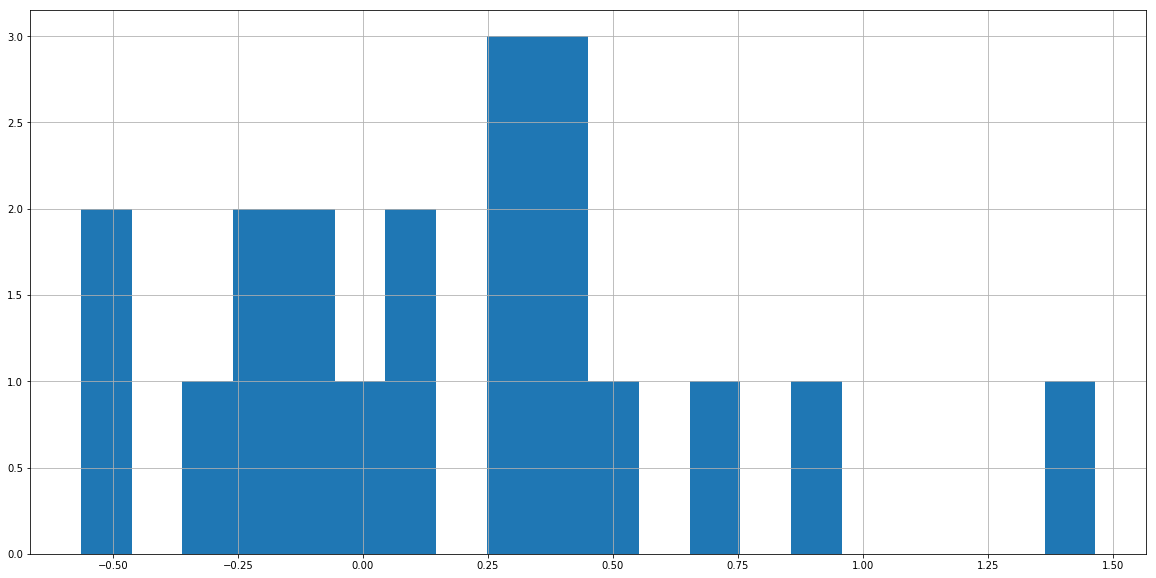

In [7]:
delta.hist(bins=20)